# Portfolio Optimizattion

Develop a portfolio optimization model implementing key financial strategies: Mean-Variance Optimization,
Max Sharpe Ratio, Minimum Variance, Equal Weight, and Hierarchical Risk Parity (HRP).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# tickers
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "BRK-B", "NVDA", "JPM", "JNJ", "V",
    "UNH", "HD", "PG", "DIS", "MA", "PYPL", "BAC", "XOM", "VZ", "ADBE",
    "CMCSA", "NFLX", "KO", "T", "PFE", "MRK", "CSCO", "PEP", "INTC", "ABT",
    "CVX", "ORCL", "WMT", "CRM", "ACN", "COST", "NKE", "TXN", "QCOM", "MCD",
    "MDT", "NEE", "HON", "LIN", "IBM", "SBUX", "LOW", "AMD", "GE", "UPS"
]

# Download data grouped by ticker
data = yf.download(tickers, start="2022-01-01", end="2025-01-01")

data

C:\Users\skabb\AppData\Local\Temp\ipykernel_28260\99996854.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2025-01-01")
[*********************100%***********************]  50 of 50 completed


Price            Close                                                  \
Ticker            AAPL         ABT         ACN        ADBE         AMD   
Date                                                                     
2022-01-03  178.645645  129.569763  385.631012  564.369995  150.240005   
2022-01-04  176.378372  126.522476  382.875244  554.000000  144.419998   
2022-01-05  171.686707  125.954018  376.132477  514.429993  136.149994   
2022-01-06  168.820679  125.935371  357.968933  514.119995  136.229996   
2022-01-07  168.987518  126.326782  351.103119  510.700012  132.000000   
...                ...         ...         ...         ...         ...   
2024-12-24  257.578674  113.126747  358.322815  447.940002  126.290001   
2024-12-26  258.396667  113.629486  357.133789  450.160004  125.059998   
2024-12-27  254.974930  113.353470  352.922638  446.480011  125.190002   
2024-12-30  251.593079  111.194641  349.266388  445.799988  122.440002   
2024-12-31  249.817368  111.500229  348.572815  444.679993  120.790001   

Price                                                                 ...  \
Ticker            AMZN        BAC       BRK-B      CMCSA        COST  ...   
Date                                                                  ...   
2022-01-03  170.404495  42.164246  300.790009  45.398449  541.812500  ...   
2022-01-04  167.522003  43.816853  308.529999  45.128689  539.441406  ...   
2022-01-05  164.356995  43.077286  309.920013  45.155670  525.760193  ...   
2022-01-06  163.253998  43.944672  313.220001  45.416428  525.645386  ...   
2022-01-07  162.554001  44.903374  319.779999  45.002815  512.623718  ...   
...                ...        ...         ...        ...         ...  ...   
2024-12-24  229.050003  43.843319  458.660004  37.394821  956.515503  ...   
2024-12-26  227.050003  44.011265  459.079987  37.248749  953.841919  ...   
2024-12-27  223.750000  43.803802  456.510010  36.937126  937.441406  ...   
2024-12-30  221.300003  43.379002  452.160004  36.411263  919.993530  ...   
2024-12-31  219.389999  43.418518  453.279999  36.547592  914.067749  ...   

Price         Volume                                                  \
Ticker          QCOM      SBUX          T      TXN      UNH      UPS   
Date                                                                   
2022-01-03   5990200   5475700   76970210  3781500  3033600  2319600   
2022-01-04   8484200   8367600   72918108  4137500  3908100  2741200   
2022-01-05  17141200   8662300  125367971  5047400  3921100  2710800   
2022-01-06   9117700   6099900   93758133  4502600  6555200  2102200   
2022-01-07   7386200  11266400   98164670  7414200  5494200  3014000   
...              ...       ...        ...      ...      ...      ...   
2024-12-24   2839600   5422000    9605900  1950900  1824400  1579200   
2024-12-26   3846900   7538700   16440500  2019000  3387000  3011100   
2024-12-27   7232500   8200400   18547500  3253500  3471800  2904000   
2024-12-30   5356000   8404500   25420000  4065200  5408600  2953900   
2024-12-31   4423300   4220700   22342800  3050500  4214000  3400800   

Price                                               
Ticker             V        VZ       WMT       XOM  
Date                                                
2022-01-03   7694500  18240100  20706600  24282400  
2022-01-04  10629300  26376800  33930000  38584000  
2022-01-05   9594600  28697300  35418000  34033300  
2022-01-06   7877500  21563800  21828900  30668500  
2022-01-07  10702100  26512500  19723500  23985400  
...              ...       ...       ...       ...  
2024-12-24   2684100  11712200   8992400   7807000  
2024-12-26   2856000  12946400  10994000   9652400  
2024-12-27   3489200  15168100  11384400  11943900  
2024-12-30   3478500  15672000   9790200  11080800  
2024-12-31   3963800  13549900  11267700  12387800  

[753 rows x 250 columns]

When downloading multiple tickers without group_by='ticker', yfinance returns a MultiIndex DataFrame where the first level is the price type (Open, High, Low, Close, etc.) and the second level is the ticker symbol. So to get the Close prices only:

In [2]:
close_prices = data['Close']  # Select first level 'Close'
close_prices = close_prices.dropna()  # Drop any rows with missing values
close_prices

Ticker,AAPL,ABT,ACN,ADBE,AMD,AMZN,BAC,BRK-B,CMCSA,COST,...,QCOM,SBUX,T,TXN,UNH,UPS,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,178.645645,129.569763,385.631012,564.369995,150.240005,170.404495,42.164246,300.790009,45.398449,541.812500,...,172.123077,107.447945,15.259243,171.990738,475.618256,183.909851,215.660492,41.324306,45.965813,56.124844
2022-01-04,176.378372,126.522476,382.875244,554.000000,144.419998,167.522003,43.816853,308.529999,45.128689,539.441406,...,173.065903,105.200989,15.385254,172.171219,464.842285,187.174576,216.663696,42.135975,45.123707,58.235924
2022-01-05,171.686707,125.954018,376.132477,514.429993,136.149994,164.356995,43.077286,309.920013,45.155670,525.760193,...,172.391129,101.701660,15.727283,168.579819,463.696533,184.822906,214.267822,42.569393,45.733841,58.960232
2022-01-06,168.820679,125.935371,357.968933,514.119995,136.229996,163.253998,43.944672,313.220001,45.416428,525.645386,...,171.882736,102.346291,15.667281,168.525635,444.720245,186.614624,214.024307,42.364506,45.606728,60.347008
2022-01-07,168.987518,126.326782,351.103119,510.700012,132.000000,162.554001,44.903374,319.779999,45.002815,512.623718,...,166.761856,99.058746,16.202524,161.920349,434.256805,187.923950,211.306992,43.257732,46.042072,60.841660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,257.578674,113.126747,358.322815,447.940002,126.290001,229.050003,43.843319,458.660004,37.394821,956.515503,...,157.558884,88.799522,22.202490,189.411423,500.394104,122.463478,319.580597,37.876404,92.203255,104.494308
2024-12-26,258.396667,113.629486,357.133789,450.160004,125.059998,227.050003,44.011265,459.079987,37.248749,953.841919,...,156.738251,90.725426,22.212162,188.712585,505.387177,122.560463,319.839752,38.028667,92.312698,104.582695
2024-12-27,254.974930,113.353470,352.922638,446.480011,125.190002,223.750000,43.803802,456.510010,36.937126,937.441406,...,155.462845,91.110611,22.115421,188.171234,504.240234,122.317986,317.597229,37.990604,91.188507,104.572884


Now close_prices is a DataFrame of Close prices indexed by date and columns as tickers.

Calculate daily returns

In [3]:
# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Annualize returns and covariance
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
num_assets = len(tickers)
risk_free_rate = 0.15

print(close_prices.head())
print(returns.head())

Ticker            AAPL         ABT         ACN        ADBE         AMD  \
Date                                                                     
2022-01-03  178.645645  129.569763  385.631012  564.369995  150.240005   
2022-01-04  176.378372  126.522476  382.875244  554.000000  144.419998   
2022-01-05  171.686707  125.954018  376.132477  514.429993  136.149994   
2022-01-06  168.820679  125.935371  357.968933  514.119995  136.229996   
2022-01-07  168.987518  126.326782  351.103119  510.700012  132.000000   

Ticker            AMZN        BAC       BRK-B      CMCSA        COST  ...  \
Date                                                                  ...   
2022-01-03  170.404495  42.164246  300.790009  45.398449  541.812500  ...   
2022-01-04  167.522003  43.816853  308.529999  45.128689  539.441406  ...   
2022-01-05  164.356995  43.077286  309.920013  45.155670  525.760193  ...   
2022-01-06  163.253998  43.944672  313.220001  45.416428  525.645386  ...   
2022-01-07  162.554

### Portfolio metrics functions

In portfolio optimization, three primary metrics are used to evaluate and compare investment strategies: expected return, volatility, and the Sharpe ratio. 

The **expected return** represents the average annualized return the portfolio is projected to earn based on historical or forecasted asset returns. 

**Volatility**, measured as the standard deviation of returns, quantifies the portfolio’s total risk — the higher the volatility, the more uncertain the returns.

The **Sharpe ratio** combines these two by measuring the risk-adjusted return, i.e., how much excess return is earned per unit of risk above the risk-free rate.

These metrics are computed using the portfolio weights, mean returns, and the covariance matrix of asset returns. They are then used as objective functions in various optimization models — for example, maximizing the Sharpe ratio, minimizing volatility, or maximizing return for a given risk. Constraints (such as full capital allocation) and bounds (like no short selling) are applied to ensure practical, real-world portfolio solutions. Together, these metrics form the foundation for constructing efficient portfolios aligned with different investor preferences.

In [4]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_ret, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

## Step 3: Optimization techniques

### 3.1 Mean-Variance (target return) Optimization - maximize return for given risk

**Mean-Variance Optimization (MVO)**, introduced by Harry Markowitz, is a foundational concept in modern portfolio theory. It aims to construct an optimal portfolio by selecting asset weights that maximize the expected return for a given level of risk (or equivalently, minimize risk for a given expected return).

In this specific implementation, the goal is to maximize portfolio return, subject to:

Full investment constraint (weights sum to 1),

Bounds on asset weights (e.g., no short-selling if lower bound = 0),

Additional constraints as needed (e.g., target risk level or diversification requirements).

The optimization problem is solved using SciPy’s minimize function with the SLSQP (Sequential Least Squares Programming) method.

In [5]:
def max_return_portfolio():
    # Maximize return under full investment and weights bounds
    def neg_return(weights):
        return -np.dot(weights, mean_returns)
    
    opt = minimize(neg_return, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return opt.x

### 3.2 Max Sharpe Ratio (Tangency Portfolio)

The **Sharpe Ratio** measures the risk-adjusted return of a portfolio by comparing its excess return (above the risk-free rate) to its volatility. The Tangency Portfolio is the portfolio on the efficient frontier that has the highest Sharpe Ratio, meaning it provides the best return per unit of risk.

This optimization aims to maximize the Sharpe Ratio, subject to:

Full investment (weights sum to 1),

Asset weight bounds (e.g., no short-selling),

Other optional constraints.

In this implementation:

The objective function neg_sharpe_ratio returns the negative Sharpe Ratio so that the minimize function can find the maximum.

The optimization is solved using SciPy’s minimize with the SLSQP method.

This approach is popular for constructing portfolios that aim to achieve the most efficient risk-return trade-off possible.

In [6]:
def max_sharpe_ratio_portfolio():
    opt = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=(mean_returns, cov_matrix, risk_free_rate),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return opt.x

### 3.3 Minimum Variance Portfolio

The **Minimum Variance Portfolio (MVP)** is the portfolio that achieves the lowest possible volatility (risk), regardless of expected returns. It lies at the leftmost point of the efficient frontier, making it ideal for highly risk-averse investors.

This approach minimizes portfolio variance (or standard deviation) under constraints:

Full investment (weights sum to 1),

No short-selling or other weight bounds, unless specified.

In this implementation:

The objective function portfolio_volatility computes the portfolio's total standard deviation.

The minimize function from SciPy is used with the SLSQP algorithm, subject to the given constraints and bounds.

The result is a diversified, low-risk allocation that minimizes the overall portfolio fluctuations — especially valuable during uncertain market conditions.

In [7]:
def min_variance_portfolio():
    opt = minimize(portfolio_volatility, num_assets * [1. / num_assets,], args=(mean_returns, cov_matrix),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return opt.x

### 3.4 Equal Weight Portfolio

The Equal Weight Portfolio is the simplest form of asset allocation, where each asset in the portfolio is assigned an equal proportion of the total capital.

This strategy assumes:

No preference among assets,

No need for forecasts or optimizations,

Each asset contributes equally to the portfolio's exposure.

In this implementation:

The weights are computed by assigning 1/N to each of the N assets, resulting in a uniform distribution of capital.

While this method does not optimize for risk or return, it serves as a useful benchmark against more advanced strategies like Mean-Variance or Maximum Sharpe. It often performs surprisingly well in practice due to its simplicity, diversification, and avoidance of estimation errors.

In [8]:
def equal_weight_portfolio():
    return np.array(num_assets * [1. / num_assets])

### 3.5 Hierarchical Risk Parity (HRP) Portfolio

The Hierarchical Risk Parity (HRP) portfolio is an advanced asset allocation strategy that combines hierarchical clustering with risk budgeting to distribute capital more robustly across assets.

Unlike traditional mean-variance optimization, HRP:

Avoids direct matrix inversion, reducing sensitivity to estimation errors,

Uses a dendrogram-based clustering to group assets by correlation,

Allocates capital recursively based on cluster-level variances.

Key steps in HRP:

- Compute a distance matrix from the correlation matrix.

- Perform hierarchical clustering to organize assets by similarity.

Apply a recursive bisection algorithm to allocate weights:

Clusters with lower variance receive more capital.

Allocations are updated in a top-down fashion through the cluster tree.

In [9]:
def correl_dist(corr):
    """Compute distance matrix from correlation matrix for clustering"""
    dist = np.sqrt(0.5 * (1 - corr))
    return dist

def get_quasi_diag(link):
    """Sort clustered items by distance to get ordering for HRP"""
    link = link.astype(int)
    sort_idx = []

    def recursive_sort(node):
        if node < len(cov_matrix):
            sort_idx.append(node)
        else:
            recursive_sort(link[node - len(cov_matrix), 0])
            recursive_sort(link[node - len(cov_matrix), 1])

    recursive_sort(link.shape[0] + len(cov_matrix) - 2)
    return sort_idx

def get_cluster_var(cov, cluster_items):
    """Calculate variance per cluster"""
    cov_slice = cov.loc[cluster_items, cluster_items]
    weights = np.linalg.inv(cov_slice).sum(axis=1)
    weights /= weights.sum()
    var = np.dot(weights.T, np.dot(cov_slice, weights))
    return var

def hrp_allocation(cov, corr):
    dist = correl_dist(corr)
    link = linkage(squareform(dist), 'single')
    sort_ix = get_quasi_diag(link)
    sorted_tickers = cov.index[sort_ix].tolist()

    hrp = pd.Series(1, index=sorted_tickers)

    def recursive_bipartition(items):
        if len(items) == 1:
            return
        split = len(items) // 2
        cluster1 = items[:split]
        cluster2 = items[split:]
        var1 = get_cluster_var(cov, cluster1)
        var2 = get_cluster_var(cov, cluster2)
        alpha = 1 - var1 / (var1 + var2)
        recursive_bipartition(cluster1)
        recursive_bipartition(cluster2)
        for i in cluster1:
            hrp[i] *= alpha
        for i in cluster2:
            hrp[i] *= (1 - alpha)

    recursive_bipartition(sorted_tickers)
    hrp /= hrp.sum()
    # Reorder back to original order
    return hrp.reindex(cov.index).fillna(0).values

### Calculate HRP weights

In [10]:
corr_matrix = returns.corr()
hrp_weights = hrp_allocation(cov_matrix, corr_matrix)

C:\Users\skabb\AppData\Local\Temp\ipykernel_28260\1987975305.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5274549249733773' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hrp[i] *= alpha


### Calculate weights for all portfolios

In [11]:
weights_max_ret = max_return_portfolio()
weights_max_ret

array([1.00689113e-15, 4.41185220e-16, 9.65790726e-17, 0.00000000e+00,
       1.91501334e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.64075726e-17, 0.00000000e+00, 0.00000000e+00,
       6.64765000e-16, 1.25643131e-16, 1.83186799e-15, 0.00000000e+00,
       2.64199852e-16, 1.87055138e-16, 3.57975504e-17, 0.00000000e+00,
       0.00000000e+00, 1.13619494e-16, 0.00000000e+00, 5.24887941e-17,
       0.00000000e+00, 0.00000000e+00, 2.07665944e-17, 5.99452877e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.90246510e-16, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.62432588e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.92318021e-16, 1.06475931e-16,
       2.99627066e-16, 0.00000000e+00, 1.75300869e-16, 0.00000000e+00,
       2.59033784e-18, 7.30963181e-17])

In [12]:
weights_max_sharpe = max_sharpe_ratio_portfolio()
weights_max_sharpe

array([2.46676245e-16, 0.00000000e+00, 9.74426911e-16, 8.46726709e-15,
       4.73941198e-15, 4.87758664e-16, 3.22461387e-15, 0.00000000e+00,
       1.53624887e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.08492478e-15, 2.92813848e-01, 0.00000000e+00,
       5.97464627e-16, 0.00000000e+00, 0.00000000e+00, 3.68596107e-15,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.50185967e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.60133877e-17, 0.00000000e+00,
       0.00000000e+00, 4.92724052e-15, 2.58773891e-01, 0.00000000e+00,
       0.00000000e+00, 9.61573780e-16, 0.00000000e+00, 6.87036474e-15,
       2.39291090e-15, 3.24112823e-16, 0.00000000e+00, 2.12226745e-15,
       0.00000000e+00, 2.51134702e-15, 0.00000000e+00, 0.00000000e+00,
       3.02191037e-01, 1.46221224e-01])

In [13]:
weights_min_var = min_variance_portfolio()
weights_min_var

array([4.83370750e-18, 0.00000000e+00, 0.00000000e+00, 1.54953469e-17,
       0.00000000e+00, 0.00000000e+00, 1.61531876e-17, 0.00000000e+00,
       5.15679270e-03, 0.00000000e+00, 0.00000000e+00, 2.53504000e-18,
       6.12145005e-02, 9.10387243e-04, 1.64815290e-02, 8.66808895e-03,
       2.71841875e-18, 1.24527509e-02, 3.61077954e-02, 0.00000000e+00,
       1.87988620e-01, 0.00000000e+00, 1.01796023e-01, 0.00000000e+00,
       2.12127092e-18, 0.00000000e+00, 1.12263104e-01, 6.57894845e-04,
       7.47079188e-18, 9.66469070e-02, 6.31459350e-03, 0.00000000e+00,
       0.00000000e+00, 2.01651427e-17, 9.77940916e-18, 2.50339959e-02,
       1.55208049e-02, 0.00000000e+00, 5.10864994e-02, 8.04830451e-18,
       5.92616625e-03, 2.64637507e-18, 4.43161227e-03, 9.63118209e-03,
       1.99274040e-02, 4.37310949e-18, 4.42932292e-03, 7.16620295e-02,
       1.08488518e-01, 3.72034779e-02])

In [14]:
weights_equal = equal_weight_portfolio()
weights_equal

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

### Show results

In [15]:
def display_portfolio(name, weights):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol
    print(f"{name} Portfolio:")
    print(f"  Expected Annual Return: {ret:.2%}")
    print(f"  Annual Volatility: {vol:.2%}")
    print(f"  Sharpe Ratio: {sharpe:.2f}")
    print()

display_portfolio("Max Return", weights_max_ret)
display_portfolio("Max Sharpe Ratio", weights_max_sharpe)
display_portfolio("Min Variance", weights_min_var)
display_portfolio("Equal Weight", weights_equal)
display_portfolio("Hierarchical Risk Parity (HRP)", hrp_weights)


Max Return Portfolio:
  Expected Annual Return: 65.22%
  Annual Volatility: 55.27%
  Sharpe Ratio: 0.91

Max Sharpe Ratio Portfolio:
  Expected Annual Return: 39.49%
  Annual Volatility: 22.71%
  Sharpe Ratio: 1.08

Min Variance Portfolio:
  Expected Annual Return: 9.76%
  Annual Volatility: 11.49%
  Sharpe Ratio: -0.46

Equal Weight Portfolio:
  Expected Annual Return: 8.61%
  Annual Volatility: 16.73%
  Sharpe Ratio: -0.38

Hierarchical Risk Parity (HRP) Portfolio:
  Expected Annual Return: 7.57%
  Annual Volatility: 14.17%
  Sharpe Ratio: -0.52



### 🔍 Portfolio-by-Portfolio Explanation:

## ✅ Max Return Portfolio

Return: 65.22%

Volatility: 55.27%

Sharpe Ratio: 0.91

🔸 This strategy goes all-in on the highest-returning asset(s), regardless of risk.

🔸 It offers a very high return, but at the cost of high volatility (risk).

🔸 The Sharpe ratio is decent, showing that the return justifies the risk to some extent — but it’s still quite aggressive.

### ⭐ Max Sharpe Ratio Portfolio

Return: 39.49%

Volatility: 22.71%

Sharpe Ratio: 1.08

🔸 This portfolio aims to maximize return per unit of risk, resulting in the highest Sharpe ratio here.

🔸 It offers a strong return but with much lower volatility than the max return portfolio.

🔸 Often considered the most efficient portfolio in traditional finance.

### 🛡️ Minimum Variance Portfolio

Return: 9.76%

Volatility: 11.49%

Sharpe Ratio: -0.46

🔸 Focuses on minimizing volatility, without regard to expected return.

🔸 Very conservative — lowest risk, but return is low and underperforms the risk-free rate (hence, negative Sharpe).

🔸 Suitable in extremely uncertain markets or for risk-averse investors.


### ⚖️ Equal Weight Portfolio

Return: 8.61%

Volatility: 16.73%

Sharpe Ratio: -0.38

🔸 Allocates equally across all assets, regardless of return or risk.

🔸 Simple and naive but often used as a benchmark.

🔸 Again, negative Sharpe ratio suggests underperformance vs. the risk-free rate.

### 🧠 Hierarchical Risk Parity (HRP) Portfolio

Return: 7.57%

Volatility: 14.17%

Sharpe Ratio: -0.52

🔸 Uses machine learning techniques (clustering) to balance risk across correlated assets.

🔸 Relatively moderate risk and return — the goal is robustness, not necessarily high performance.

🔸 The negative Sharpe ratio here indicates that returns did not compensate for the risk, likely due to noisy data or market conditions.

Five portfolio strategies tested, each with distinct objectives and results. 

Below is a summary of what each method achieved based on expected annual return, volatility (risk), and Sharpe ratio (risk-adjusted return):

| Portfolio                          | Expected Return | Volatility | Sharpe Ratio | Interpretation                                                          |
| ---------------------------------- | --------------: | ---------: | -----------: | ----------------------------------------------------------------------- |
| **Max Return**                     |      **65.22%** |     55.27% |         0.91 | Very high return, but also very risky; suited for aggressive investors. |
| **Max Sharpe Ratio**               |      **39.49%** |     22.71% |     **1.08** | Best overall trade-off; high return with reasonable risk.               |
| **Min Variance**                   |           9.76% | **11.49%** |        -0.46 | Safest portfolio, but too conservative with poor returns.               |
| **Equal Weight**                   |           8.61% |     16.73% |        -0.38 | Simple and diversified baseline; underperforms optimized strategies.    |
| **Hierarchical Risk Parity (HRP)** |           7.57% |     14.17% |        -0.52 | Most diversified; good from a risk-distribution view, but low return.   |


### Conclusion

- Max Sharpe Ratio is the most efficient portfolio — it provides the best return per unit of risk.

- HRP offers a modern, machine learning-driven approach that avoids overfitting and doesn’t rely on matrix inversion — helpful in volatile markets.

- Classical methods like Mean-Variance and Min-Variance remain relevant but must be chosen based on investor goals (growth vs. safety).

- Equal Weight is simple but suboptimal, highlighting the power of optimization techniques.

### Plot weights for comparison

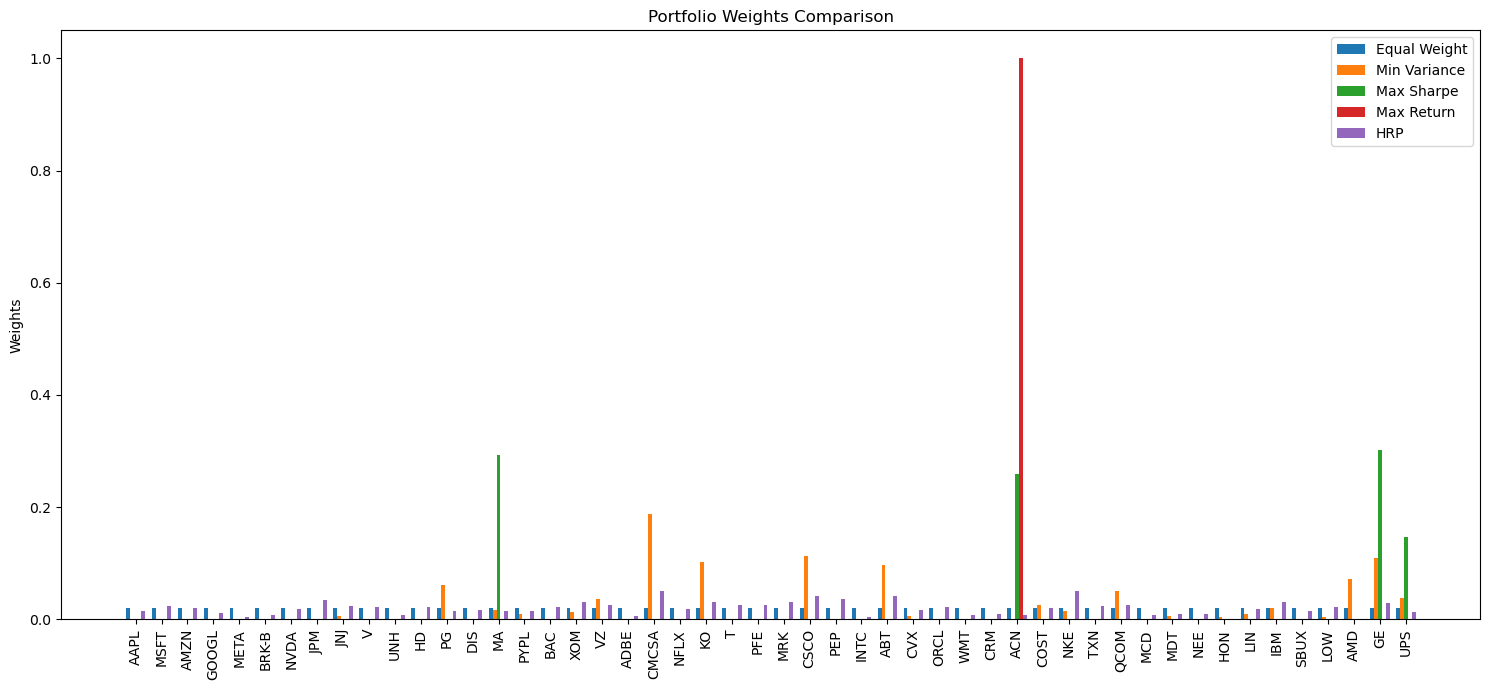

In [16]:
plt.figure(figsize=(15,7))
width = 0.15
ind = np.arange(num_assets)

plt.bar(ind, weights_equal, width, label='Equal Weight')
plt.bar(ind + width, weights_min_var, width, label='Min Variance')
plt.bar(ind + 2*width, weights_max_sharpe, width, label='Max Sharpe')
plt.bar(ind + 3*width, weights_max_ret, width, label='Max Return')
plt.bar(ind + 4*width, hrp_weights, width, label='HRP')

plt.xticks(ind + 2*width, tickers, rotation=90)
plt.ylabel('Weights')
plt.title('Portfolio Weights Comparison')
plt.legend()
plt.tight_layout()
plt.show()